# Question n°1

In [1]:
#We generate from an alpha distribution with jax
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [15]:
def simulation_alpha_stable(alpha, beta, gamma, delta, n, key):
    """
    Generate n samples from an alpha-stable distribution with parameters alpha, beta, gamma, delta.
    """
    #0. Splitting the random number generation into two parts to avoid using the same key
    # for uniform and exponential random variables

    key_u, key_w = jax.random.split(key)

    #1. Generate exponentia l random variables
    w = jax.random.exponential(key_w, shape=(n,))

    #2. Generate uniform random variables
    u = jax.random.uniform(key_u, minval= -np.pi/2, maxval= np.pi/2, shape=(n,))
    
    #3. Generate y
    
    if alpha == 1:
        y = (2/np.pi)*(((np.pi/2) + beta * u) * jnp.tan(u) - beta * jnp.log(((np.pi/2)*w*jnp.cos(u))/(np.pi/2 + beta * u)))
    else:
        S = (1+beta*beta*(jnp.tan(np.pi/2 * alpha)**2))**(1/(2*alpha))
        B = 1/alpha * jnp.arctan(beta * jnp.tan(np.pi/2 * alpha))
        y = S * (jnp.sin(alpha) * (u + B) / (jnp.cos(u))**(1/alpha)) * (jnp.cos(u-alpha*(u+B))/w)**((1-alpha)/alpha)
    
    #4. Generate the correct y
    
    y = gamma * y + delta
    return y

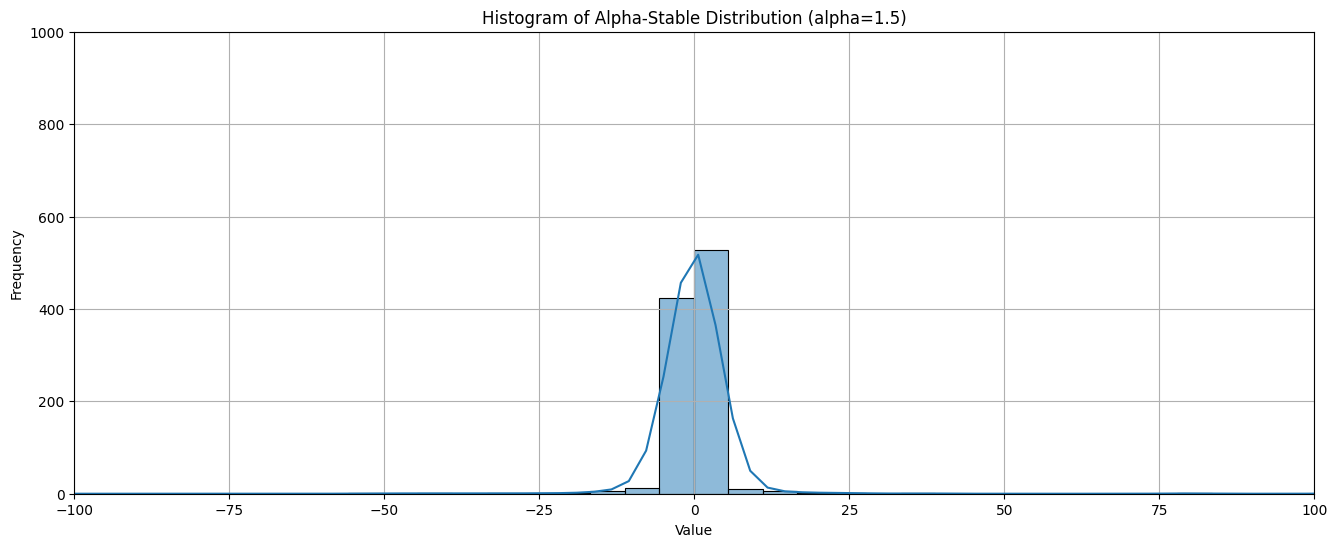

In [23]:
y = simulation_alpha_stable(1, 0, 0.5, 0, 1000, jax.random.PRNGKey(2))
# Plotting the histogram
plt.figure(figsize=(16, 6))
sns.histplot(y, bins=100, kde=True)
plt.title('Histogram of Alpha-Stable Distribution (alpha=1.5)')
plt.xlabel('Value')
plt.xlim(-100,100)
plt.ylabel('Frequency')

plt.ylim(0, 1000)
plt.grid()
plt.show()

# Question n°2